In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import datetime
from torch.utils.data import DataLoader, Dataset
import torch
sys.path.append(os.path.abspath('../src'))

from data_tools.data_utils import create_data_split
from PNN.train_utils import train, EarlyStopper, train_type_name
from PNN.NowcastPNN import PropNet, NowcastPNNDOW, TypePNN

# Set seeds for batch shuffle and during training

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 123
set_seed(seed)
project_dir = project_dir = Path.cwd().parent
D = 40
M = 50
T = 50
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15
start_year = 2013

deng_delays = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
type_name_props = pd.read_csv(project_dir / "data" / "transformed" / "type_name_props.csv")

deng_delays["Collection date"] = pd.to_datetime(deng_delays["Collection date"])
deng_delays = deng_delays.set_index("Collection date")

N = denv_df['Type'].nunique()
type_name_all = type_name_props.columns[1:]

In [2]:
# Drop last D days as they are incomplete
complete_df = deng_delays.iloc[D-1: -D+1]
complete_df = complete_df[complete_df.index.to_period("Y") >= pd.Period(start_year, freq="Y")]
# First D days are not usable
n_usable_obs = len(complete_df)

# Split the number of usable obs over the 3 datasets
train_end_idx = int(train_prop*n_usable_obs)
val_end_idx = train_end_idx + int(val_prop*n_usable_obs)

train_df = complete_df.iloc[0: train_end_idx]
val_df = complete_df.iloc[train_end_idx - D : val_end_idx]
test_df = complete_df.iloc[val_end_idx - D : ]


In [3]:
print(train_df.index)
print(val_df.index)
print(test_df.index)


DatetimeIndex(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12',
               '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16',
               '2013-02-17', '2013-02-18',
               ...
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27'],
              dtype='datetime64[ns]', name='Collection date', length=2757, freq=None)
DatetimeIndex(['2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22',
               '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
               '2020-07-27', '2020-07-28',
               ...
               '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03',
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-09'],
              dtype='datetime64[ns]', name='Collection date', length=630, freq=None)
DatetimeIndex(['2022-03-01', '2022-03-02', '2022-

In [4]:
type_name_tensor = np.load(project_dir / "data" / "transformed" / "type_name_tensor.npy")
start_date = str(denv_df['Collection date'].min())
end_date = str(pd.to_datetime(denv_df['Collection date']).max() + pd.DateOffset(months=1))


denv_dates = pd.date_range(start_date,end_date, freq='ME').to_period('M')

D_t = type_name_tensor.shape[2]

In [5]:
class type_nameDataset:
    def __init__(self, dates, type_name_tensor, type_name_props, T, D_t):
        self.dates = dates
        self.type_name_tensor = type_name_tensor
        self.type_name_props = type_name_props
        self.D_t = D_t
        self.T = T

    def get_type_name_triangle(self, date):
        date = pd.to_datetime(date).to_period('M')
        idx_range = self.dates < date
        type_name_obs = self.type_name_tensor[:, idx_range, :]
        type_name_obs = type_name_obs[:, -self.T:, :self.D_t]

        n_type, _, _ = type_name_obs.shape

        mask = self.get_mask()
        mask_broadcast = np.broadcast_to(mask, (n_type, self.D_t, self.D_t))
        type_name_obs = type_name_obs.copy()
        type_name_obs[:, -self.D_t:, :][~mask_broadcast] = 0
        
        max_val = type_name_obs.max()
        if max_val > 0:
            type_name_obs = type_name_obs / max_val
        return type_name_obs

    def get_type_name_prop(self, date):
        date = pd.to_datetime(date).to_period('M')
        idx_vals = pd.to_datetime(self.type_name_props['Collection date'].values).to_period("M") == date

        row = self.type_name_props.iloc[idx_vals, 1:]

        return row.to_numpy().flatten()

    def get_mask(self):
        mask_matrix = np.ones(shape=(self.D_t, self.D_t), dtype=bool)
        for i in range(self.D_t):
            for j in range(self.D_t):
                if i + j > self.D_t - 1:
                    mask_matrix[i, j] = False
        return mask_matrix
    
type_name_obj = type_nameDataset(denv_dates, type_name_tensor, type_name_props, T, D_t)
# type_name_obj.get_type_name_triangle("2018-01-01").shape
type_name_obj.get_type_name_prop("2018-02-10").shape

(11,)

In [6]:
# check mask works
obs = np.ones((4, 60, 36))
mask = type_name_obj.get_mask()
mask_broadcast = np.broadcast_to(mask, (4, 36, 36))  # shape matches obs[:, -36:, :]
obs[:, -36:, :][~mask_broadcast] = 0
obs

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]])

In [7]:
class ReportingDataset(Dataset):
    # first available datapoint is index self.D - 1,
    # e.g D=40, then self.df[39] is first day with a reporting triangle of length 40 

    def __init__(self, df, D, M, max_val, type_name_obj, label_type, device):
        self.M = M
        self.D = D
        self.dates = pd.to_datetime(df.copy().index[self.M-1:])
        self.df = np.array(df.copy(), dtype = np.float32)
        self.type_name_obj = type_name_obj
        self.max_val = max_val
        self.label_type = label_type
        self.device = device

        assert self.label_type in ("y", "z"), 'label_type must either be "y" or "z"'

    def __len__(self):
        return len(self.df) - self.M + 1


    def __getitem__(self, idx):
        t = idx + self.M
        obs = self.df[t-self.M: t]

        # Create observed reporting triangle
        mask = self.get_mask()
        obs_masked = obs.copy() / self.max_val
        if self.M <= self.D:
            mask = mask[-self.M:,:]
            obs_masked[-self.M:, :][~mask] = 0
        else:
            obs_masked[-self.D:, :][~mask] = 0

        obs_masked = torch.tensor(obs_masked, dtype=torch.float32)
        obs_masked = obs_masked.to(self.device)

        # Get day of the week and week num
        date = self.get_date(idx)
        dow = torch.tensor(date.weekday(), dtype=torch.int32)
        dow.to(self.device)
        # week = torch.tensor(date.isocalendar().week - 1, dtype=torch.int32)
        # week.to(self.device)

        type_name_obs = self.type_name_obj.get_type_name_triangle(date)
        type_name_prop = self.type_name_obj.get_type_name_prop(date)

        # Create y label
        y_label = torch.tensor(obs[self.M - 1, :].sum(), dtype=torch.float32)
        y_label = (y_label * type_name_prop)
        y_label = np.round(y_label)
        y_label.to(self.device)
        return (obs_masked, dow, type_name_obs), (y_label, type_name_prop)
        
    
    def get_mask(self):
        mask_matrix = np.ones(shape=(self.D, self.D), dtype=bool)
        for i in range(self.D):
            for j in range(self.D):
                if i + j > self.D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

    def get_date(self, idx):
        return self.dates[idx].date()
    
    def get_y(self, idx):
        t = idx + self.M
        y = np.array(self.df[t-1].sum())
    
        date = self.get_date(idx)
        type_name_prop = self.type_name_obj.get_type_name_prop(date)
        y = (y * type_name_prop)
        return y


max_val = train_df.values.max()

In [8]:
def eval_model(dataset, model, label_type):
    eval_loader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)

    # Put model in eval mode with dropout active
    model.eval()
    model.drop_count1.train()
    model.drop_count2.train()
    # model.drop_prop1.train()
    # model.drop_prop2.train()

    (obs_masked, dow, type_name_obs), (y_label, p_true) = next(iter(eval_loader))
    obs_masked = obs_masked.to("cpu")
    dow = dow.to("cpu")
    type_name_obs = type_name_obs.to("cpu")
    model = model.to("cpu")

    n_type_name = type_name_obs.shape[1]


    n_samples = 50
    preds = np.zeros(shape=(dataset.__len__(), n_samples, n_type_name))
    for i in range(n_samples):
        dist, p_pred, active_type_names = model(obs_masked, dow, type_name_obs)
        samples = dist.sample().numpy()
        preds[:, i, :][active_type_names] = samples

    return preds

def plot_preds(preds, dataset, type_name_all, title, other_preds=False, other_preds_label=False):
    preds_median = np.quantile(preds, 0.5, axis=1)
    dates = pd.to_datetime(dataset.dates)
    colors = plt.cm.get_cmap('tab10', len(type_name_all))
    colors = [colors(i) for i in range(len(type_name_all))]

    for s, type_name in enumerate(type_name_all):
        plt.plot(dates, preds_median[:, s], label=f'Preds: {type_name}', color=colors[s], linestyle='-')
        y_true = [dataset.get_y(i)[s] for i in range(len(dataset))]
        plt.plot(dates, y_true, label=f'True y: {type_name}', color="black")
        
        plt.legend()
        plt.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.title(f"{title} ({type_name})", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [9]:
device = "cpu"

complete_dataset = ReportingDataset(complete_df, D, M, max_val, type_name_obj, label_type='y', device=device)
train_dataset = ReportingDataset(train_df, D, M, max_val, type_name_obj, label_type='y', device=device)
val_dataset = ReportingDataset(val_df, D, M, max_val,type_name_obj, label_type='y', device=device)
test_dataset = ReportingDataset(test_df, D, M, max_val,type_name_obj, label_type='y', device=device)

# Create dataloaders, shuffle trainign data for better training
g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



early_stopper = EarlyStopper(patience=30, past_units=M, max_delay=D, weeks=False, future_obs=0, random_split=False, dow = True)
type_name_net = TypePNN(max_val=max_val, D=D, M=M, T=T, D_t=D_t, n_type_name=N)




In [10]:
train_dataset.__getitem__(0)

((tensor([[1.4432e-01, 1.6465e-01, 1.6687e-01,  ..., 6.8318e-04, 1.7079e-04,
           6.8318e-04],
          [1.2912e-01, 2.2152e-01, 1.4586e-01,  ..., 1.0248e-03, 8.5397e-04,
           5.1238e-04],
          [1.6772e-01, 1.8958e-01, 1.9829e-01,  ..., 1.1956e-03, 5.1238e-04,
           1.0248e-03],
          ...,
          [3.8292e-01, 3.3561e-01, 2.1964e-01,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [2.7737e-01, 2.9137e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [2.6371e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]]),
  tensor(5, dtype=torch.int32),
  array([[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.     

In [11]:
(obs_masked, dow, type_name_obs), y_label = next(iter(train_dataset))
type_name_obs.shape

(11, 50, 36)

In [12]:
train_type_name(type_name_net, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = device, dow = True, label_type='y')


Epoch 1 - Train loss: 2.73e+05 - Val loss: 1.75e+06 - ES count: 0
Epoch 2 - Train loss: 1.64e+05 - Val loss: 1.42e+06 - ES count: 0
Epoch 3 - Train loss: 1.42e+05 - Val loss: 1.41e+06 - ES count: 0
Epoch 4 - Train loss: 1.33e+05 - Val loss: 1.63e+06 - ES count: 1
Epoch 5 - Train loss: 1.25e+05 - Val loss: 1.6e+06 - ES count: 2
Epoch 6 - Train loss: 1.15e+05 - Val loss: 1.61e+06 - ES count: 3
Epoch 7 - Train loss: 1.07e+05 - Val loss: 2.33e+06 - ES count: 4
Epoch 8 - Train loss: 1.01e+05 - Val loss: 2.49e+06 - ES count: 5
Epoch 9 - Train loss: 9.3e+04 - Val loss: 2.71e+06 - ES count: 6
Epoch 10 - Train loss: 8.69e+04 - Val loss: 2.22e+06 - ES count: 7
Epoch 11 - Train loss: 8.48e+04 - Val loss: 2.29e+06 - ES count: 8
Epoch 12 - Train loss: 7.78e+04 - Val loss: 2.23e+06 - ES count: 9
Epoch 13 - Train loss: 7.42e+04 - Val loss: 2.8e+06 - ES count: 10
Epoch 14 - Train loss: 6.93e+04 - Val loss: 2.81e+06 - ES count: 11
Epoch 15 - Train loss: 6.64e+04 - Val loss: 3.05e+06 - ES count: 12


KeyboardInterrupt: 

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_39558/2100728357.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(type_name_all))


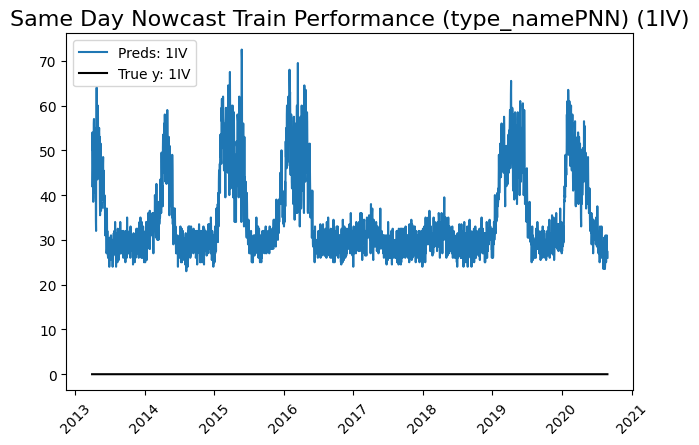

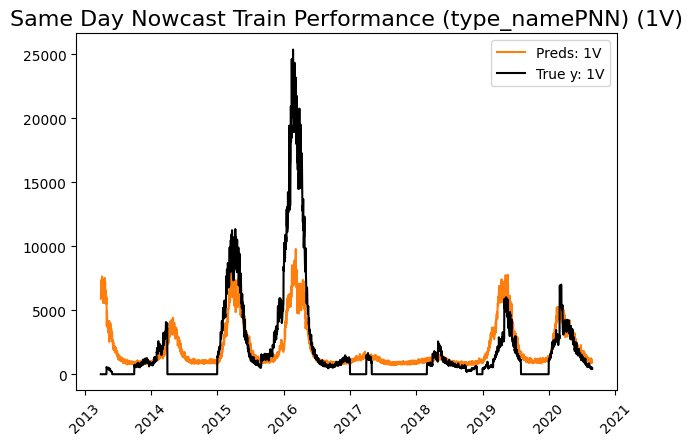

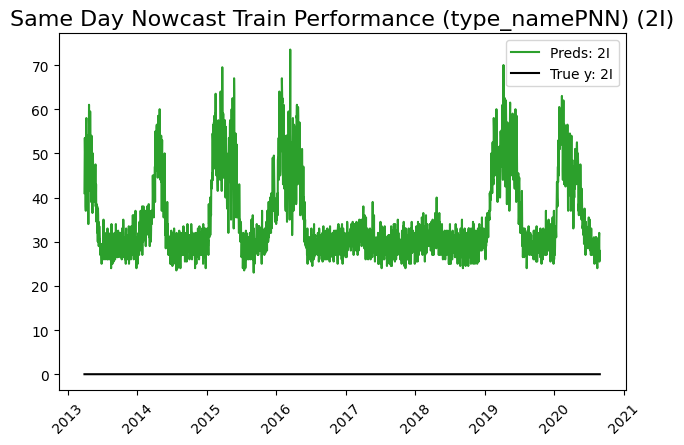

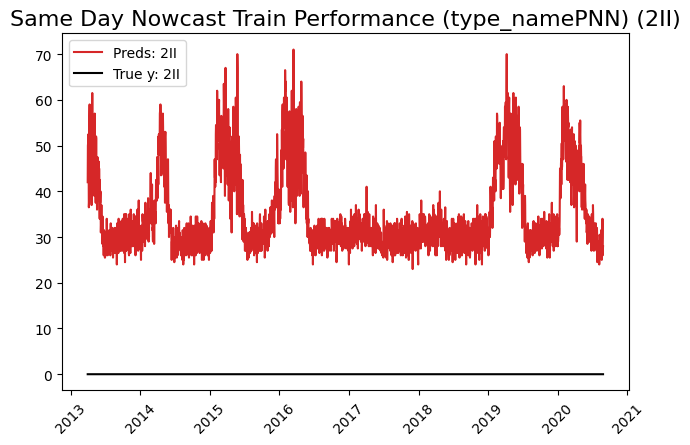

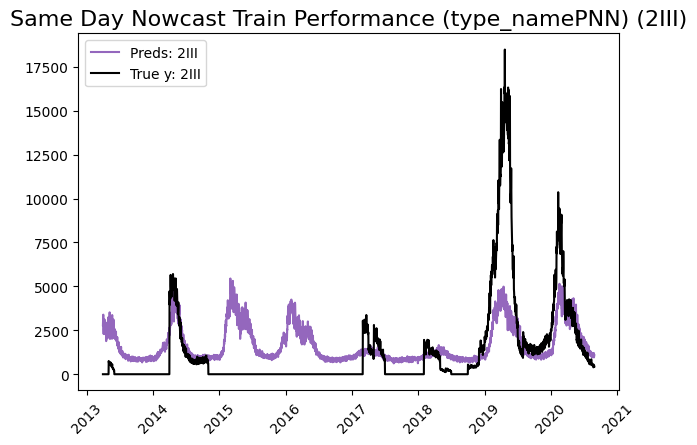

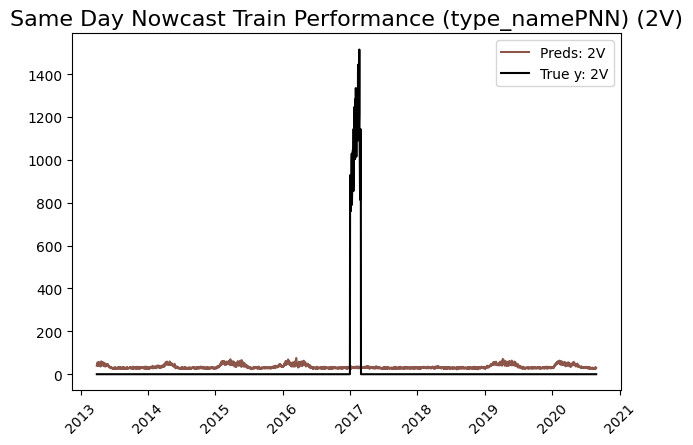

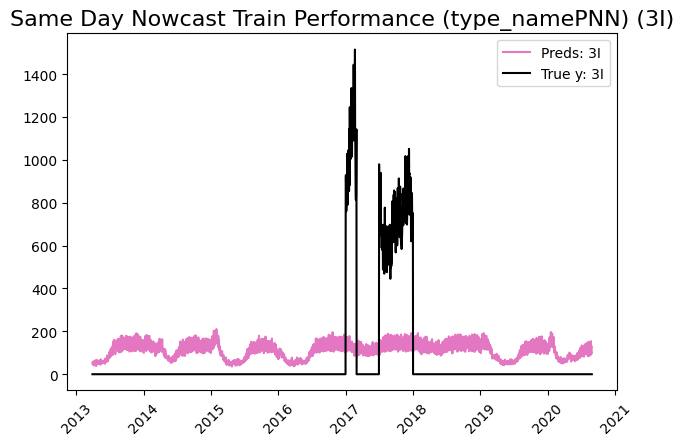

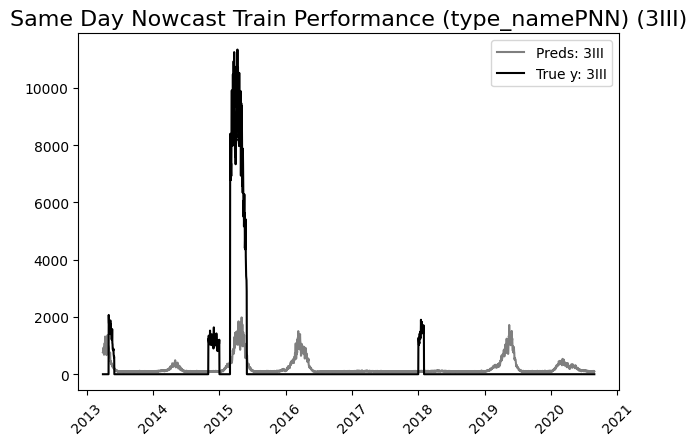

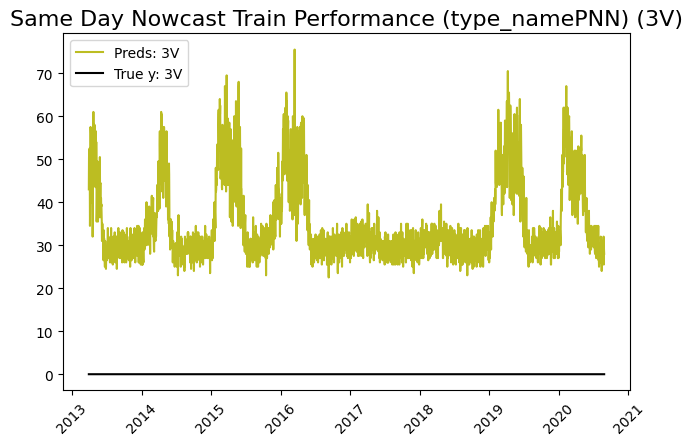

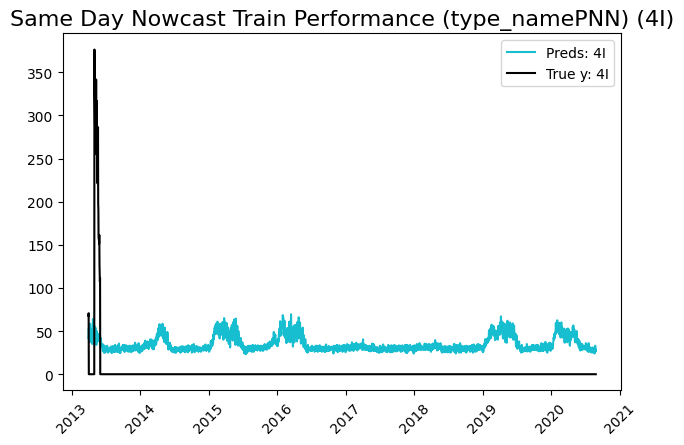

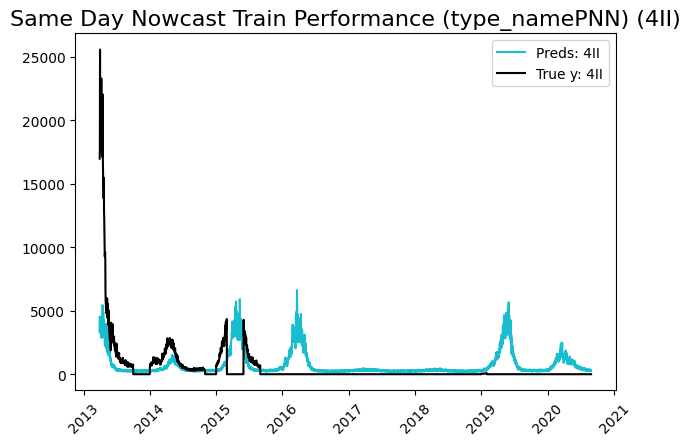

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_39558/2100728357.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(type_name_all))


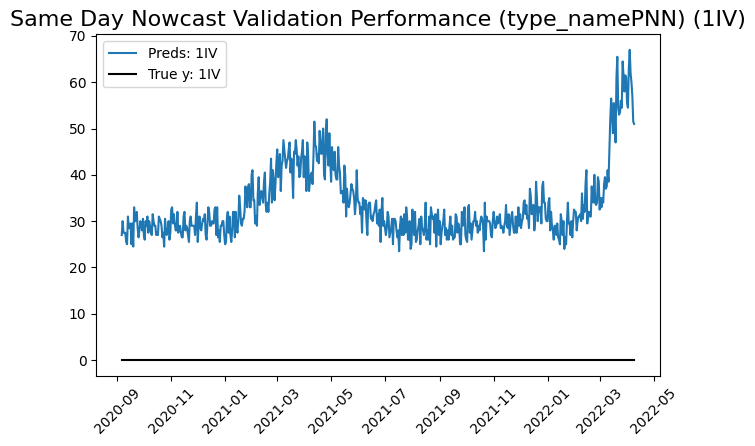

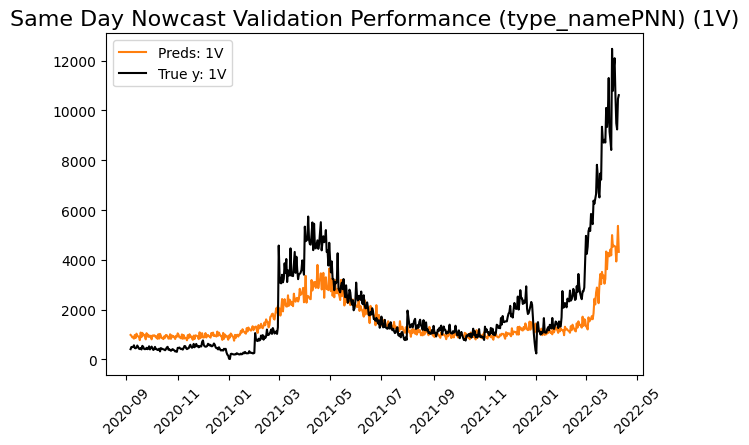

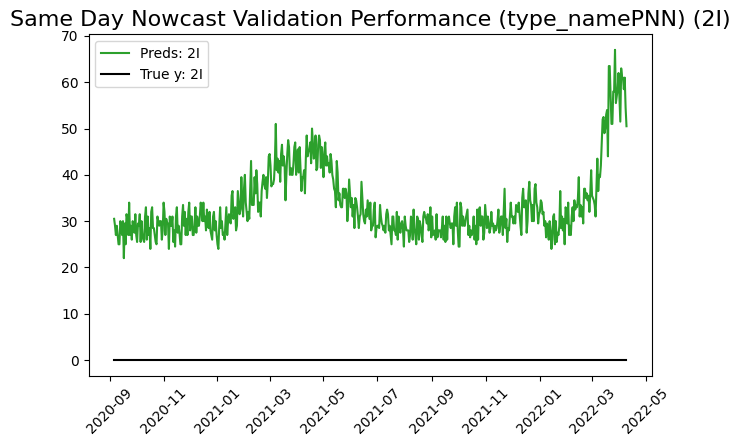

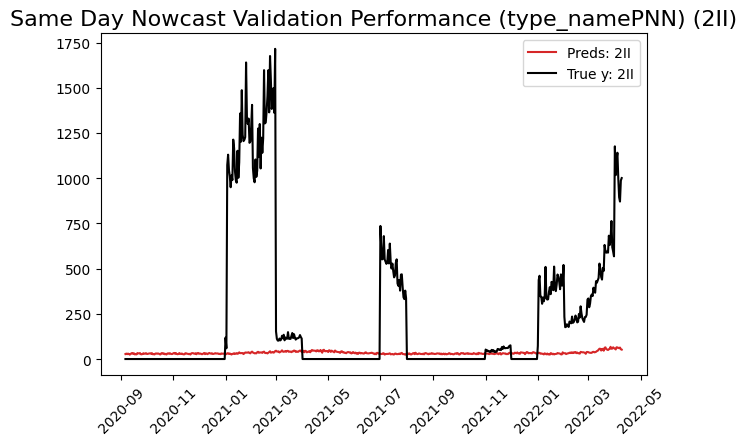

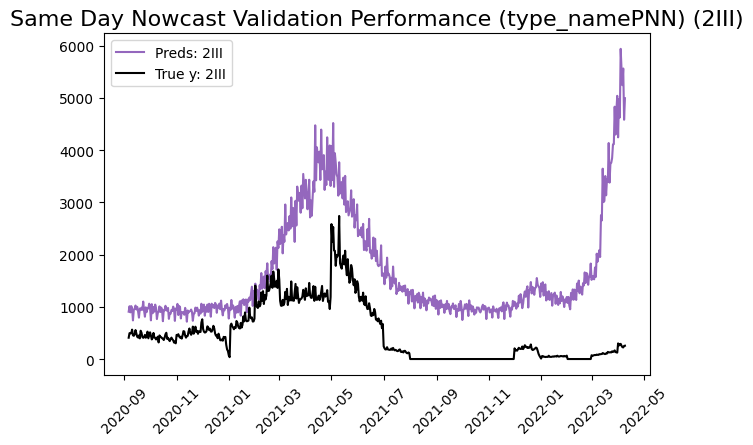

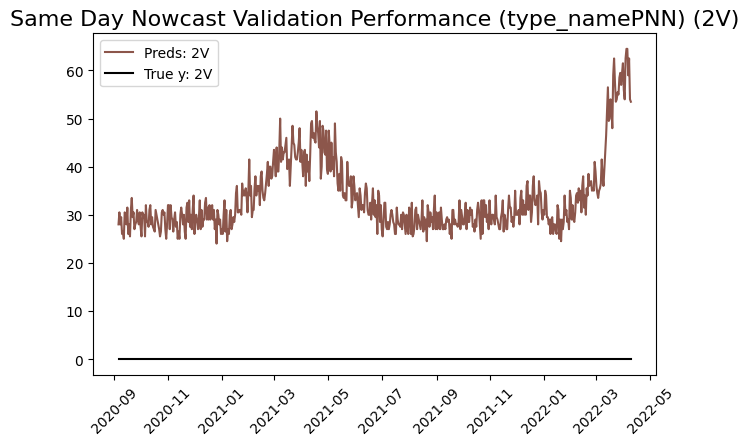

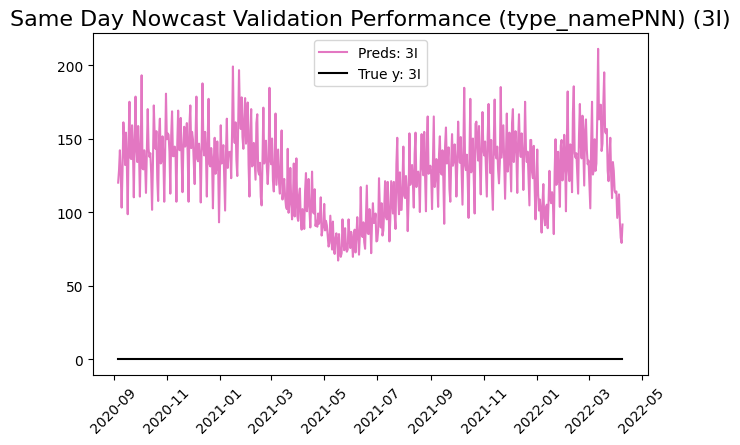

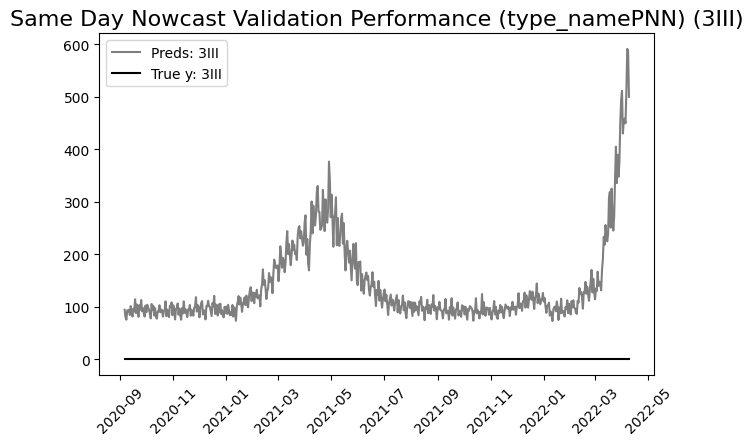

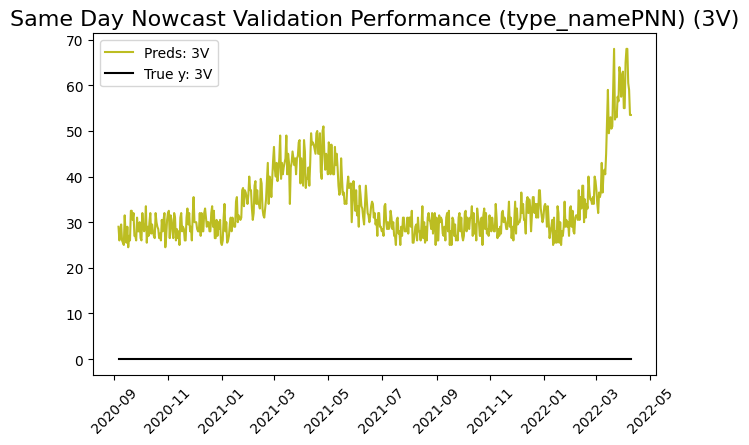

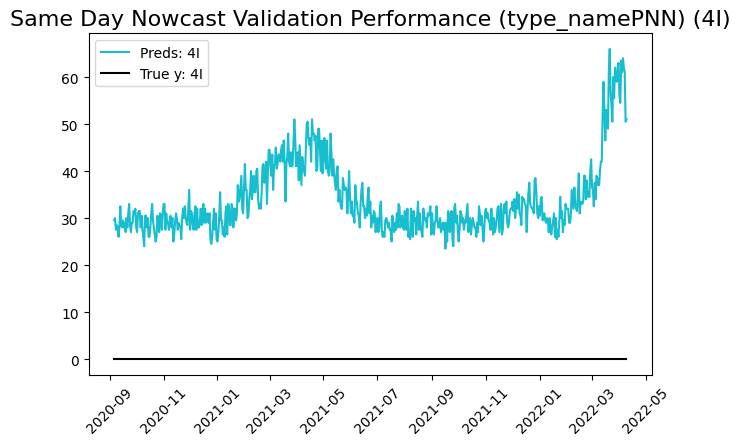

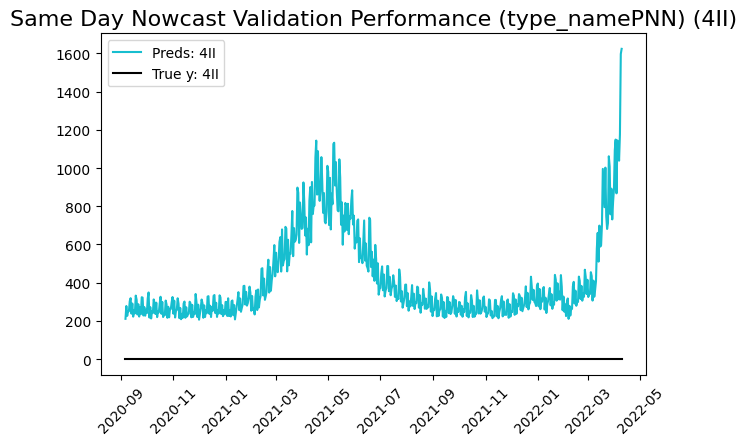

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_39558/2100728357.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(type_name_all))


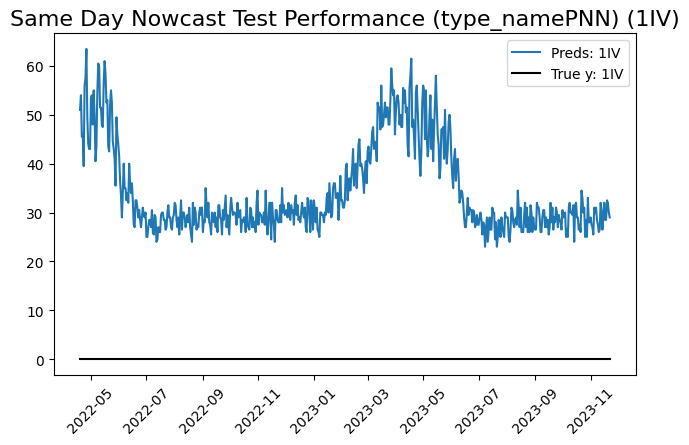

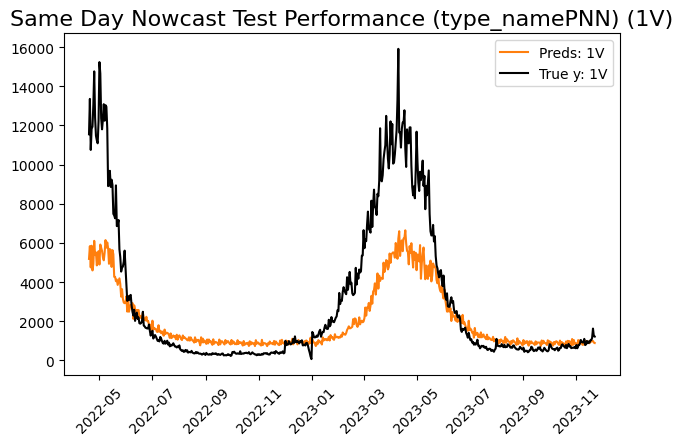

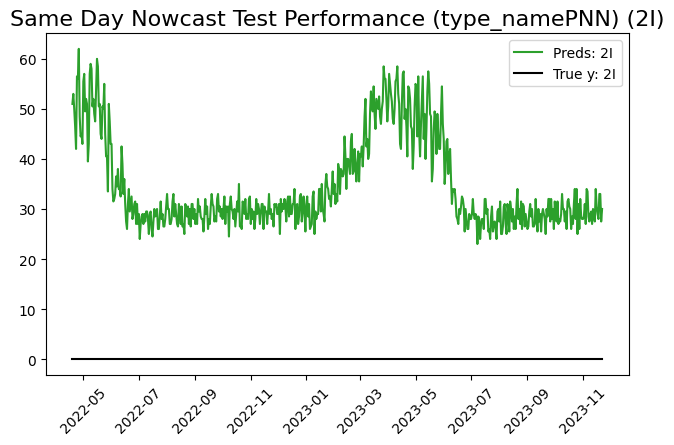

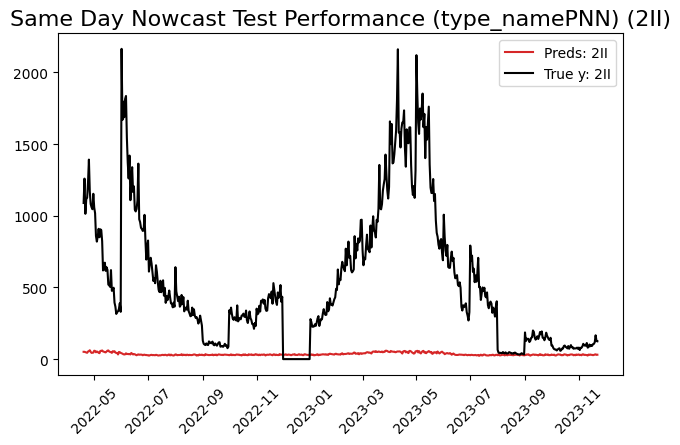

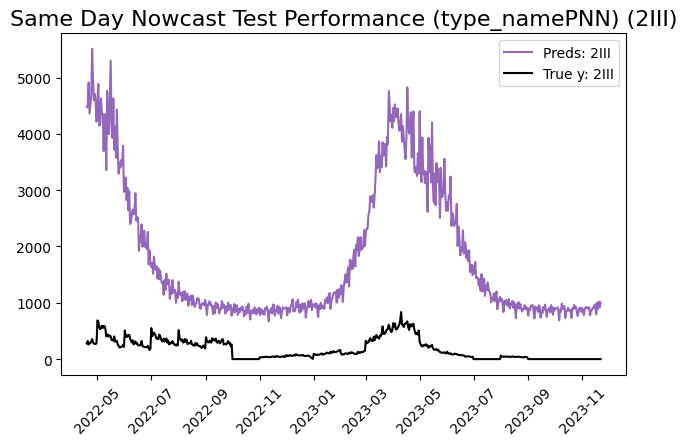

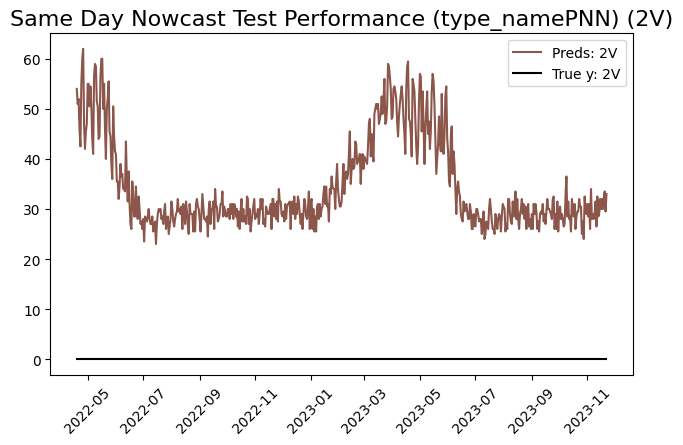

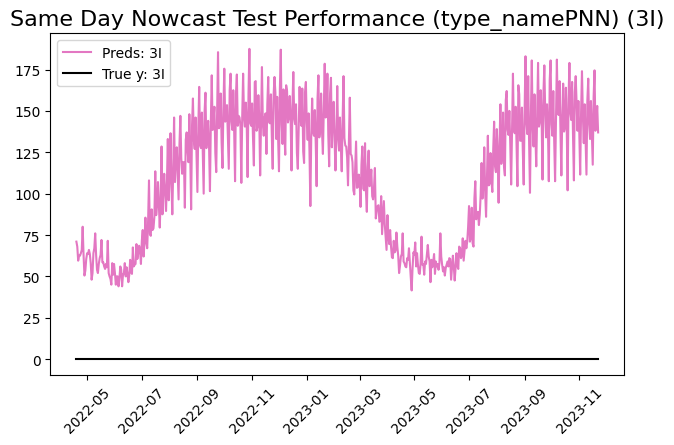

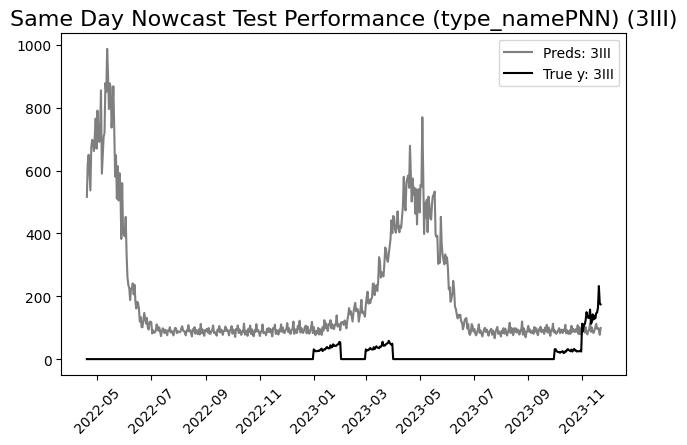

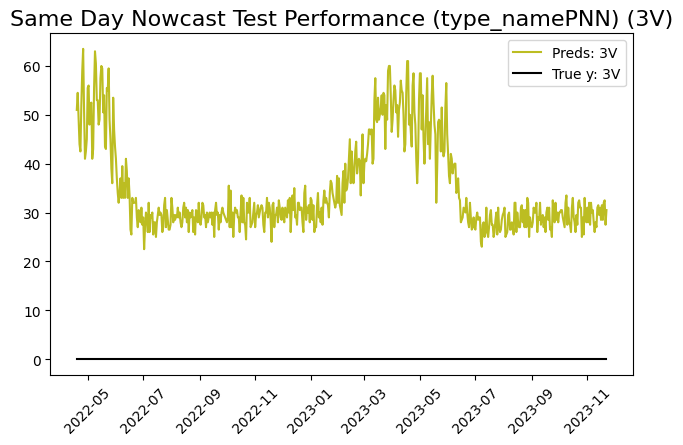

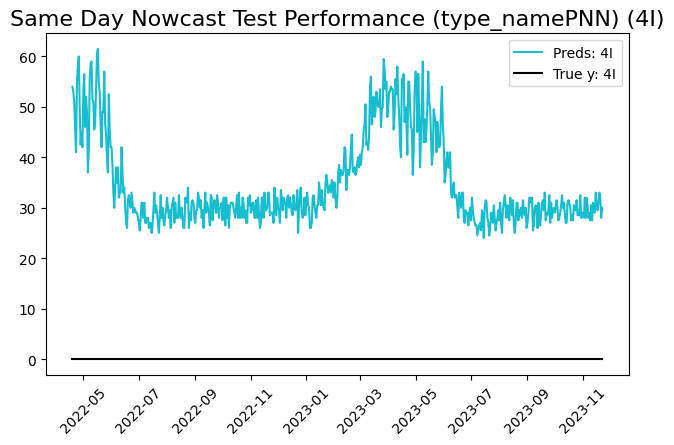

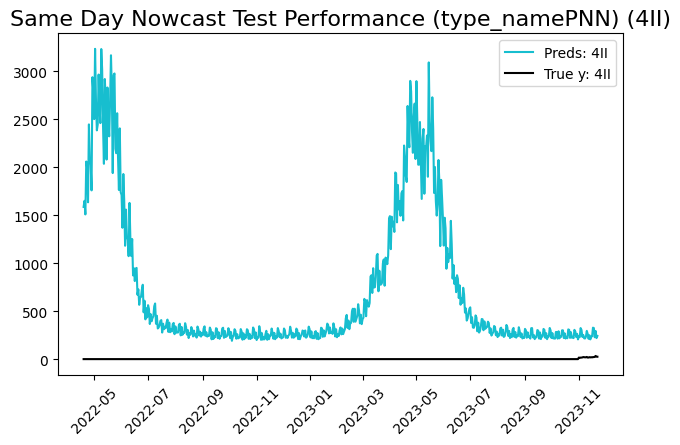

In [13]:
## Load best set of weights on test/validation set onto CPU for evaluation
type_name_pnn = TypePNN(max_val=max_val, D=D, M=M, T=T, D_t=D_t, n_type_name=N)

type_name_pnn.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-{M}-{D}"))

train_preds_prop = eval_model(train_dataset, type_name_pnn, label_type='z')
plot_preds(train_preds_prop, train_dataset, type_name_all=type_name_all, title="Same Day Nowcast Train Performance (type_namePNN)")

val_preds = eval_model(val_dataset, type_name_pnn, label_type='z')
plot_preds(val_preds, val_dataset, type_name_all=type_name_all, title="Same Day Nowcast Validation Performance (type_namePNN)")

test_preds = eval_model(test_dataset, type_name_pnn, label_type='z')
plot_preds(test_preds, test_dataset, type_name_all=type_name_all, title="Same Day Nowcast Test Performance (type_namePNN)")




